# Data Intensive Computing Final Project - Task4 - Oct. 2022
### Authors: Filippo Caliò - Dario Del Gaizo - Victor Lopo
### Team: LM10

In [ ]:
import pyspark as pysp
import pandas as pd
import numpy as np
import org.apache.spark as sp
import pyspark.sql.functions as f

from matplotlib import pyplot as plt
from collections import Counter
from pyspark.ml.stat import Correlation
from pyspark.sql import DataFrame
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml.feature import StringIndexer, PCA, VectorAssembler, UnivariateFeatureSelector
from pyspark.sql.functions import col,lit, monotonically_increasing_id
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.sql import functions as f


### Data Loading

In [ ]:
df1 = spark.read.options(header='True', inferSchema='True', delimiter=',').csv('dbfs:/FileStore/tables/student_data.csv')
df2 = spark.read.options(header='True', inferSchema='True', delimiter=',').csv('dbfs:/FileStore/tables/student_por.csv')

### Data Preprocessing

In [ ]:
diff1 = set(df1.columns).difference(df2.columns)
diff2 = set(df2.columns).difference(df1.columns)

# The total number of different rows is equal to the second dataset 
# This means that the two datasets are different (df1 is different from df2)
df1except = df1.exceptAll(df2)
total_number_diff_rows = df1except.count()
print(total_number_diff_rows)
print(df1.count())

# Same operation done in the other way (df2 is different from df1)
df2except = df2.exceptAll(df1)
total_number_diff_rows = df2except.count()
print(df2.count())
print(total_number_diff_rows)

Difference is:  0 0
395
395
649
649


In [ ]:
df = df1.union(df2)
#display(df)

In [ ]:
df.dtypes

Out[7]: [('school', 'string'),
 ('sex', 'string'),
 ('age', 'int'),
 ('address', 'string'),
 ('famsize', 'string'),
 ('Pstatus', 'string'),
 ('Medu', 'int'),
 ('Fedu', 'int'),
 ('Mjob', 'string'),
 ('Fjob', 'string'),
 ('reason', 'string'),
 ('guardian', 'string'),
 ('traveltime', 'int'),
 ('studytime', 'int'),
 ('failures', 'int'),
 ('schoolsup', 'string'),
 ('famsup', 'string'),
 ('paid', 'string'),
 ('activities', 'string'),
 ('nursery', 'string'),
 ('higher', 'string'),
 ('internet', 'string'),
 ('romantic', 'string'),
 ('famrel', 'int'),
 ('freetime', 'int'),
 ('goout', 'int'),
 ('Dalc', 'int'),
 ('Walc', 'int'),
 ('health', 'int'),
 ('absences', 'int'),
 ('G1', 'int'),
 ('G2', 'int'),
 ('G3', 'int')]

Out[5]: <AxesSubplot:>

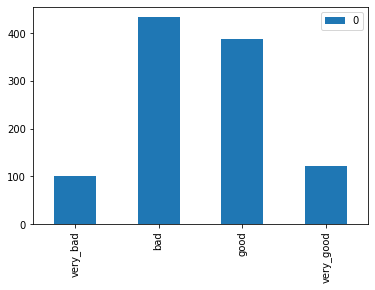

In [ ]:
# The final grade (target) is going to be group in 4 classes for the multiclass classification task

# Very bad --> grades from 0 to 7
# Bad --> grades from 7 to 11
# Good --> grades from 11 to 15
# Very good --> grades from 15 to 20


df = df.withColumn('Grade1', f.when(f.col('G1') <= 7, "very_bad")
                        .when((f.col('G1') > 7) & (f.col('G1') <= 11), "bad")
                        .when((f.col('G1') > 11) & (f.col('G1') <= 15), "good")
                       .otherwise("very_good"))

df = df.withColumn('Grade2', f.when(f.col('G2') <= 7, "very_bad")
                        .when((f.col('G2') > 7) & (f.col('G2') <= 11), "bad")
                        .when((f.col('G2') > 11) & (f.col('G2') <= 15), "good")
                       .otherwise("very_good"))

df = df.withColumn('Grade3', f.when(f.col('G3') <= 7, "very_bad")
                        .when((f.col('G3') > 7) & (f.col('G3') <= 11), "bad")
                        .when((f.col('G3') > 11) & (f.col('G3') <= 15), "good")
                       .otherwise("very_good"))


# Checking if the four labels are balanced to have a Gaussian distribution

grades = df.select('Grade3').rdd.flatMap(lambda x: x).collect()
count = Counter(grades)
grades_df = pd.DataFrame.from_dict(count, orient='index')
grades_df.plot(kind='bar')


### Train-Test split

In [ ]:
df = df.drop("G1").drop("G2").drop("G3")
input_cols = ["school", "sex", "address", "famsize", "Pstatus", "Mjob", "Fjob", "reason", "guardian", "schoolsup", "famsup", "paid", "activities", "nursery", "higher", "internet", "romantic", "Grade1", "Grade2", "Grade3"]

index_cols = ["school_Idx", "sex_Idx", "address_Idx", "famsize_Idx", "Pstatus_Idx", "Mjob_Idx", "Fjob_Idx", "reason_Idx", "guardian_Idx", "schoolsup_Idx", "famsup_Idx", "paid_Idx", "activities_Idx", "nursery_Idx", "higher_Idx", "internet_Idx", "romantic_Idx", "Grade1_Idx", "Grade2_Idx", "Grade3_Idx"]

indexer = StringIndexer(inputCols=input_cols, outputCols=index_cols)

df_indexed = indexer.fit(df).transform(df)
df_indexed = df_indexed.drop("school", "sex", "address", "famsize", "Pstatus", "Mjob", "Fjob", "reason", "guardian", "schoolsup", "famsup", "paid", "activities", "nursery", "higher", "internet", "romantic", "Grade1", "Grade2", "Grade3")


/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
<command-4428537841257942>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+attr)
<command-4428537841257942>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+attr)


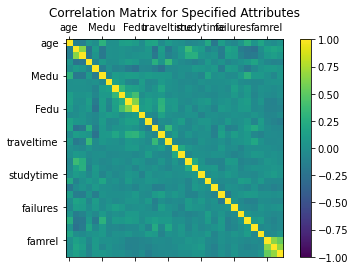

In [ ]:
# convert to vector column first
vector_col = "corr_features"
assembler_corr = VectorAssembler(inputCols=df_indexed.columns, outputCol=vector_col)
df_vector = assembler_corr.transform(df_indexed).select(vector_col)

matrix = Correlation.corr(df_vector, vector_col)
cor_np = matrix.collect()[0][matrix.columns[0]].toArray()

def plot_corr_matrix(correlations,attr,fig_no):
    fig=plt.figure(fig_no)
    ax=fig.add_subplot(111)
    ax.set_title("Correlation Matrix for Specified Attributes")
    ax.set_xticklabels(['']+attr)
    ax.set_yticklabels(['']+attr)
    cax=ax.matshow(correlations,vmax=1,vmin=-1)
    fig.colorbar(cax)
    plt.show()

# The features with more correlation are Grade 1 and Grade 2
# Grade 1 and Grade 2 are grades of previous test in the course
# They don't have direct influence in the final grade (one final exam)

plot_corr_matrix(cor_np, df_indexed.columns, 234)

In [ ]:
# 15 % of the data goes to the test set and 85 % to the train set

perc = 0.85
train_df, test_df = df_indexed.randomSplit([perc, 1-perc], seed=42)
#display(train_df)
#display(test_df)

### Cross-validation to search the optimal number of features

In [ ]:
train_df_labels = train_df.select("Grade3_Idx")
train_df_features = train_df.drop("Grade3_Idx")

assembler = VectorAssembler(inputCols=train_df_features.columns, outputCol="features")
train_df_features_top_study = assembler.transform(train_df_features)

In [ ]:
# To train the models is neccessary that the train dataset is assembled

train_df_features_assembler = train_df_features_top_study.select("features")
train_df_features_assembler = train_df_features_assembler.withColumn("id",monotonically_increasing_id() )
train_df_labels = train_df_labels.withColumn( "id", monotonically_increasing_id() )
train_df_merged = train_df_features_assembler.join(train_df_labels,train_df_features_assembler.id == train_df_labels.id, how='inner')
train_df_merged = train_df_merged.drop("id").drop("id")
train_df_merged = train_df_merged.withColumnRenamed("Grade3_Idx", "label")

In [ ]:
list_features = range(5, 16, 1)
name_list_dict = {}
selector = UnivariateFeatureSelector(featuresCol="features", outputCol="selectedFeatures", labelCol="label", selectionMode="numTopFeatures")

for num_features in list_features:
    selector.setFeatureType("categorical").setLabelType("categorical").setSelectionThreshold(num_features)
    result = selector.fit(train_df_merged)
    name_list_dict["features_" + str(num_features)] = np.array(train_df.columns)[result.selectedFeatures] #dictionary {features_num -> list of features}
    
display(name_list_dict)

{'features_5': array(['failures', 'Grade1_Idx', 'Grade2_Idx', 'higher_Idx', 'Medu'],
       dtype='<U14'),
 'features_6': array(['failures', 'Grade1_Idx', 'Grade2_Idx', 'higher_Idx', 'Medu',
        'Mjob_Idx'], dtype='<U14'),
 'features_7': array(['failures', 'Grade1_Idx', 'Grade2_Idx', 'higher_Idx', 'Medu',
        'Mjob_Idx', 'Fedu'], dtype='<U14'),
 'features_8': array(['failures', 'Grade1_Idx', 'Grade2_Idx', 'higher_Idx', 'Medu',
        'Mjob_Idx', 'Fedu', 'studytime'], dtype='<U14'),
 'features_9': array(['failures', 'Grade1_Idx', 'Grade2_Idx', 'higher_Idx', 'Medu',
        'Mjob_Idx', 'Fedu', 'studytime', 'Dalc'], dtype='<U14'),
 'features_10': array(['failures', 'Grade1_Idx', 'Grade2_Idx', 'higher_Idx', 'Medu',
        'Mjob_Idx', 'Fedu', 'studytime', 'Dalc', 'goout'], dtype='<U14'),
 'features_11': array(['failures', 'Grade1_Idx', 'Grade2_Idx', 'higher_Idx', 'Medu',
        'Mjob_Idx', 'Fedu', 'studytime', 'Dalc', 'goout', 'address_Idx'],
       dtype='<U14'),
 'features_12':

In [ ]:
keys = name_list_dict.keys()
assembled_list = []
i = 0

for k in keys:
    out = "features_" + str(5+i)
    assembler = VectorAssembler(inputCols=name_list_dict[k], outputCol=out)
    transformed_df = assembler.transform(train_df_features)
    assembled_list.append(transformed_df.select(out))
    i = i + 1


In [ ]:
final_dfs =  []
train_df_labels = train_df_labels.withColumn("id", monotonically_increasing_id())

for i in range(len(assembled_list)):
    temp = assembled_list[i]
    temp = temp.withColumn("id", monotonically_increasing_id())
    final_dfs.append(temp.join(train_df_labels, temp.id == train_df_labels.id, how='inner'))
    final_dfs[i] = final_dfs[i].drop("id").drop("id")
    
for a in final_dfs:
    #display(a)

In [ ]:
# Store the accuracies of all the models obtained in the cross validation in a list

accuracies = {}
i = 0

reduce_final_dfs = final_dfs[:6]

for a in reduce_final_dfs:
    #display(a)

In [ ]:
# For loop to cross-validate the models with different features

models = []
for df in reduce_final_dfs:
    out = "features_" + str(5+i)
    df = df.withColumnRenamed(out, "features").withColumnRenamed("Grade3_Idx", "label")
    rf = RandomForestClassifier(labelCol="label", featuresCol="features", seed=42)
    evaluator = MulticlassClassificationEvaluator()  

    pipeline = Pipeline(stages=[rf])
    paramGrid = (ParamGridBuilder().addGrid(rf.numTrees, [64, 128]).addGrid(rf.maxDepth, [0, 3]).build())

    crossval = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=paramGrid,
        evaluator=evaluator,
        numFolds=10)

    model = crossval.fit(df)
    models.append(model)

    avgMetricsGrid = model.avgMetrics
    model_name = "model_" + str(5+i)
    accuracies[model_name] = max(avgMetricsGrid)
    i = i + 1
    
    

In [ ]:
# Print the accuracies of each model

print(accuracies)

{'model_5': 0.8577192723180639, 'model_6': 0.8586912017076074, 'model_7': 0.8470210463093004, 'model_8': 0.8418410940604029, 'model_9': 0.8181003395331349, 'model_10': 0.8425706459569655}


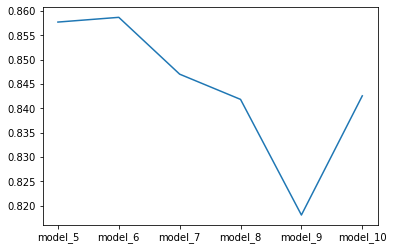

In [ ]:
lists = accuracies.items() 

# unpack a list of pairs into two tuples

x, y = zip(*lists) 

plt.plot(x, y)
plt.show()

In [ ]:
# Assemble the test dataset to be able to make predictions

input_cols = ["failures", "Grade1_Idx", "Grade2_Idx", "higher_Idx", "Medu", "Mjob_Idx"]
test_df_6 = test_df.select("failures", "Grade1_Idx", "Grade2_Idx", "higher_Idx", "Medu", "Mjob_Idx", "Grade3_Idx")
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
transformed_df_6 = assembler.transform(test_df_6)
transformed_df_6 = transformed_df_6.withColumnRenamed("Grade3_Idx", "label")
test_df_assembled_6 = transformed_df_6.select("features", "label")



In [ ]:
# Cross-validation of the model of 6 features

to_train = final_dfs[1].withColumnRenamed("features_6", "features").withColumnRenamed("Grade3_Idx", "label")
rf = RandomForestClassifier(labelCol="label", featuresCol="features", seed=42)
evaluator = MulticlassClassificationEvaluator().setLabelCol("label").setPredictionCol("prediction").setMetricName("accuracy")

# Pipeline and grid to find the optimal parameters of the random forest

pipeline = Pipeline(stages=[rf])
paramGrid = (ParamGridBuilder().addGrid(rf.numTrees, [100, 300]).addGrid(rf.maxDepth, [0, 4]).build())

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=10)

model_6 = crossval.fit(to_train)


avgMetricsGrid = model_6.avgMetrics
accuracy_6 = max(avgMetricsGrid)

In [ ]:
# Accuracy of the cross-validation 


accuracy_6

Out[23]: 0.8566779396659564

In [ ]:
predictions_6 = model_6.transform(test_df_assembled_6)

evaluator_6 = MulticlassClassificationEvaluator().setLabelCol("label").setPredictionCol("prediction").setMetricName("accuracy")

accuracy_6 = evaluator_6.evaluate(predictions_6)

# Accuracy over the test set (slightly lower than in the cross validation)

print(accuracy_6)

0.8376623376623377


In [ ]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", seed=42)
evaluator = MulticlassClassificationEvaluator()  

# Pipeline to search the most optimal parameters for the random tree

pipeline = Pipeline(stages=[rf])
paramGrid = (ParamGridBuilder().addGrid(rf.numTrees, [100, 200]).addGrid(rf.maxDepth, [0, 3]).build())

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=10)

# Train the model with 32 features

model = crossval.fit(train_df_merged)

In [ ]:
in_cols = ["age", "Medu", "Fedu", "traveltime", "studytime", "failures", "famrel","freetime", "goout", "Dalc", "Walc", "health", "absences", "school_Idx", "sex_Idx", "address_Idx", "famsize_Idx", "Pstatus_Idx", "Mjob_Idx", "Fjob_Idx", "reason_Idx", "guardian_Idx", "schoolsup_Idx", "famsup_Idx", "paid_Idx", "activities_Idx", "nursery_Idx", "higher_Idx", "internet_Idx", "romantic_Idx", "Grade1_Idx", "Grade2_Idx"]

assembler = VectorAssembler(inputCols=in_cols, outputCol="features")
full_prediction_test_df = assembler.transform(test_df)
full_prediction_test_df = full_prediction_test_df.withColumnRenamed("Grade3_Idx", "label")
full_prediction_test_df = full_prediction_test_df.select("features", "label")

In [ ]:
predictions = model.transform(full_prediction_test_df)

evaluator = MulticlassClassificationEvaluator().setLabelCol("label").setPredictionCol("prediction").setMetricName("accuracy")

accuracy = evaluator.evaluate(predictions)

# This is the accuracy of the 32 feature model over the test set

print(accuracy)

0.7402597402597403


In [ ]:
train_df_PCA = train_df.withColumnRenamed("Grade3_Idx", "label")
test_df_PCA = test_df.withColumnRenamed("Grade3_Idx", "label")
assembler_PCA = VectorAssembler( inputCols=train_df_PCA.columns[:-1], outputCol="features")

pca = PCA(k=6, inputCol="features", outputCol="pcaFeature")

model_PCA_RF = RandomForestClassifier(labelCol="label", featuresCol="pcaFeature", seed=42, numTrees = 300, maxDepth= 4)
pipeline_PCA_LR = Pipeline (stages=[assembler_PCA,pca, model_PCA_RF])
model_PCA_RF = pipeline_PCA_LR.fit(train_df_PCA)
predictions_PCA_RF = model_PCA_RF.transform(test_df_PCA)
evaluator_PCA_RF = MulticlassClassificationEvaluator().setLabelCol("label").setPredictionCol("prediction").setMetricName("accuracy")
accuracy_PCA_RF = evaluator_PCA_RF.evaluate(predictions_PCA_RF)
print(accuracy_PCA_RF)

# Not optimal approach (low accuracy compared to previous models)

0.6038961038961039


In [ ]:
# Why is the accuracy so low? Let's see the variance explained by each component of the pca

assembler_variance = VectorAssembler(inputCols=train_df_PCA.columns, outputCol="features")
train_df_PCA_variance = assembler_variance.transform(train_df_PCA)
model_variance = pca.fit(train_df_PCA_variance)
dense_vector = model_variance.explainedVariance

Out[18]: <BarContainer object of 6 artists>

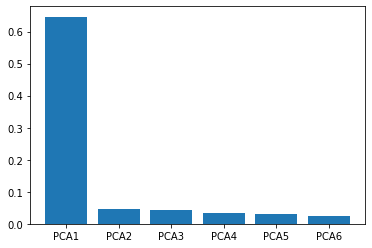

In [ ]:
import matplotlib.pyplot as plt

xaxis = ["PCA1", "PCA2", "PCA3", "PCA4", "PCA5", "PCA6" ]
plt.bar(xaxis, dense_vector)

# Only the first component achieves to get a high variance (the rest components are really low)
# 64% of variance is really low to perform the prediction task correctly